# Fast Filtering with Large Option Panels: Implications for Asset Pricing

As we don't have access to the data used in the paper, we will simulate data from the option pricing models whown in the figures (page 59 environ) and then estimate the model given the artificial data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import simulation

## 1. Simulating data

### 1.1. SV Heston model

We will first simulate the data from the simple Stochastic Volatility model of Heston. The model is given by the following SDEs:

$$
\begin{aligned}
dS_t &= (r_t - \delta_t + \eta_s V_t) S_t dt + \sqrt{V_t} S_t dW_t^S \\
dV_t &= \kappa (\theta - V_t) dt + \sigma \sqrt{V_t} dW_t^v
\end{aligned}
$$

where $W_t^S$ and $W_t^v$ are two correlated Brownian motions with correlation $\rho$. We will simulate the data for the following parameters:

We will start by the state on the 1st of January 2014 and simulate the data for 100 days with 30 options per day.

In [2]:
# Params
S0 = 1824.36
V0 = 0.0001
T = 100/365 # Time in days
N = 100 

r = 0.01
delta = 0.0509

# Params from the article
kappa = 1.6999
theta = 0.0334
sigma = 0.3715
rho = -0.9085
eta_s = 2.6623
eta_v = 1.1156

simuSV = simulation.SimulationSV(kappa, theta, sigma, rho, eta_s, eta_v)

# Simulate
S, V = simuSV.SV_heston(S0, V0, r, delta, T, N)

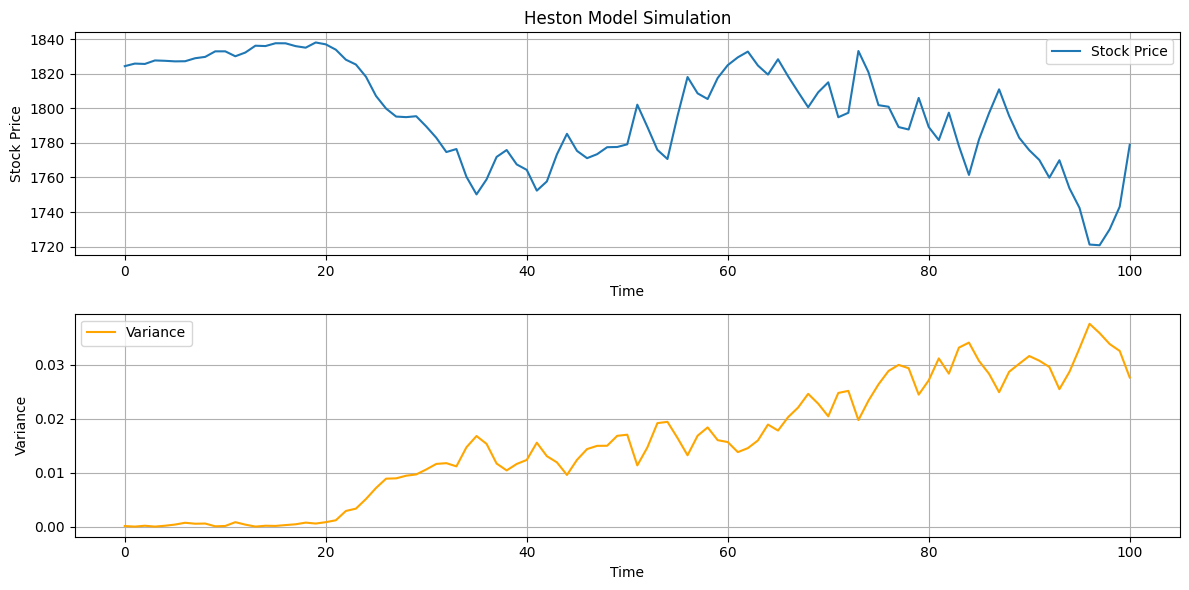

In [3]:
# time
time = [i for i in range(N+1)]

# Plot results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, S, label="Stock Price")
plt.title("Heston Model Simulation")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, V, label="Variance", color="orange")
plt.xlabel("Time")
plt.ylabel("Variance")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

### 1.2. SVJR model

In [4]:
# Params from the article
kappa = 1.5382
theta = 0.0236
sigma = 0.3682
rho = -0.9187
eta_s = 2.5562
eta_v = 1.2466
lmda = 0.6380
mu_s = -0.0064
sigma_s = 0.0937
eta_js = 0.03
sigma_c = 3.0308

simuSVJR = simulation.SimulationSVJR(kappa, theta, sigma, rho, eta_s, eta_v, lmda, mu_s, sigma_s, eta_js, sigma_c)

# Simulate
S, V = simuSVJR.SVJR(S0, V0, r, delta, T, N)

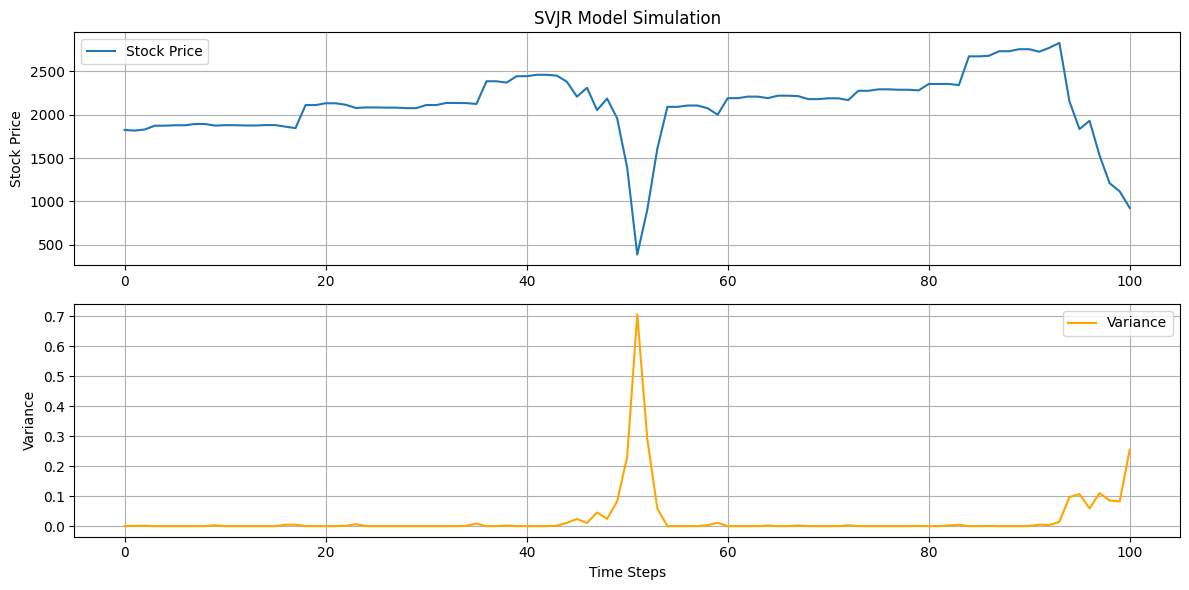

In [5]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(S, label="Stock Price")
plt.title("SVJR Model Simulation")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(V, label="Variance", color="orange")
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### 1.3. SVJV model

In [6]:
# Params from the article
kappa = 1.1777
theta = 0.0310
sigma = 0.3651
rho = -0.9242
eta_s = 2.3032
eta_v = 0.5569
lmda = 0.6716
mu_v = 0.0314
eta_jv = -0.0057
sigma_c = 3.0963

simuSVJV = simulation.SimulationSVJV(kappa, theta, sigma, rho, eta_s, eta_v, lmda, mu_v, eta_jv, sigma_c)

# Simulate
S, V = simuSVJV.SVJV(S0, V0, r, delta, T, N)

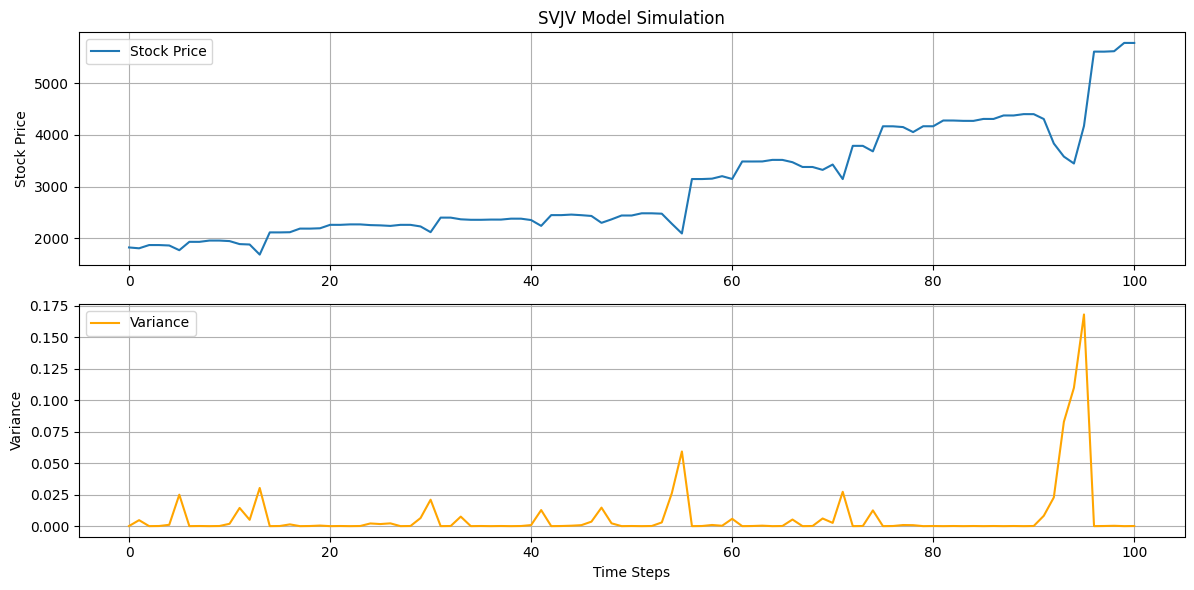

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(S, label="Stock Price")
plt.title("SVJV Model Simulation")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(V, label="Variance", color="orange")
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

### 1.4. SVCJ model

In [8]:
# Params from the article
kappa = 0.9613
theta = 0.0282
sigma = 0.3586
rho = -0.9191
eta_s = 2.7095
eta_v = 0.6239
lmda = 0.7249
mu_s = 0.0320
sigma_s = 0.0872
eta_js = 0.0562
mu_v = 0.0727
eta_jv = 0.0562
rho_j = -0.7382
sigma_c = 3.0978

simuSVCJ = simulation.SimulationSVCJ(kappa, theta, sigma, rho, eta_s, eta_v, lmda, 
                                     mu_s, sigma_s, eta_js, mu_v, eta_jv, rho_j, sigma_c)

# Simulate
S, V = simuSVCJ.SVCJ(S0, V0, r, delta, T, N)

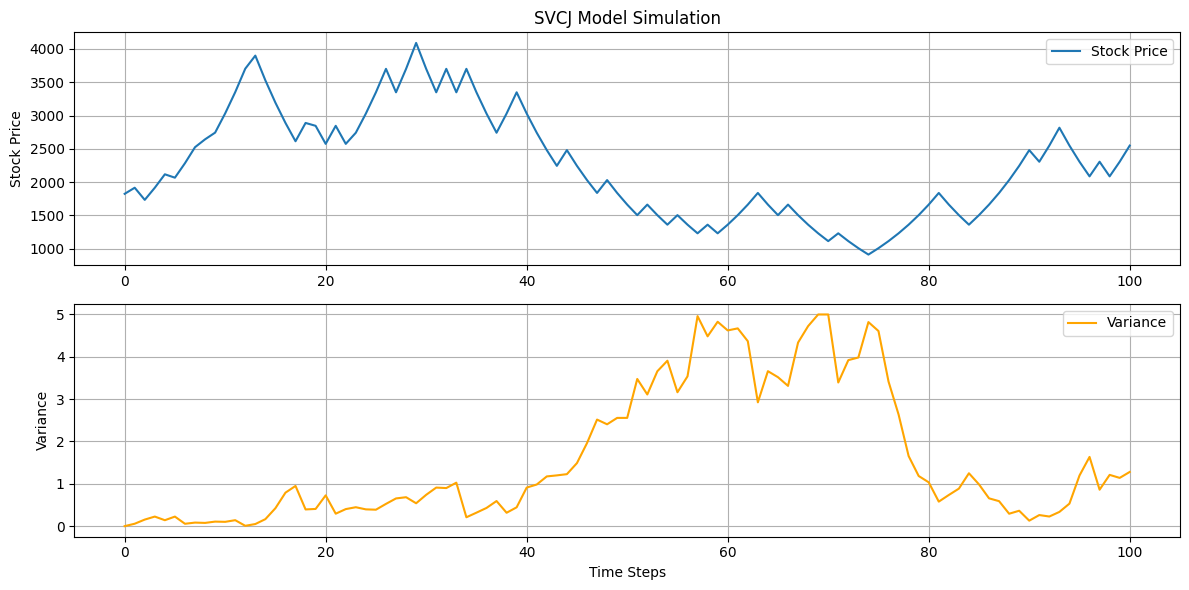

In [9]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(S, label="Stock Price")
plt.title("SVCJ Model Simulation")
plt.ylabel("Stock Price")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(V, label="Variance", color="orange")
plt.ylabel("Variance")
plt.xlabel("Time Steps")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## 2. Boostrap Filter (Feynman-Kac) for the model under consideration

In this section, we will implement the boostrap filter for the model under consideration. The boostrap filter is a Monte Carlo method that allows to estimate the filtering distribution of the state variables given the observations. The algorithm is as follows:

1. Initialize the particles $x_0^{(i)}$ for $i=1,\ldots,N$ from the prior distribution $p(x_0)$.

2. For $t=1,\ldots,T$:
    1. For $i=1,\ldots,N$:
        1. Sample $x_t^{(i)}$ from the proposal distribution $q(x_t|x_{t-1}^{(i)},y_t)$.
        2. Compute the importance weight $w_t^{(i)} = \frac{p(y_t|x_t^{(i)}) p(x_t^{(i)}|x_{t-1}^{(i)})}{q(x_t^{(i)}|x_{t-1}^{(i)},y_t)}$.
    2. Normalize the weights $w_t^{(i)}$.
    3. Resample the particles $x_t^{(i)}$ with replacement according to the weights $w_t^{(i)}$.

3. Compute the estimate of the filtering distribution as $\hat{p}(x_t|y_{1:t}) = \sum_{i=1}^N w_t^{(i)} \delta_{x_t^{(i)}}(x_t)$.

We will implement the boostrap filter for the model under consideration.

In [10]:
import BootstrapFilter as bf

# Params from the article

In [11]:
class BootstrapFilter:
    def __init__(self, num_particles, prior_mean, prior_std):
        """
        Initialize the bootstrap filter.

        Parameters:
        - num_particles: Number of particles in the filter.
        - prior_mean: Mean of the prior distribution.
        - prior_std: Standard deviation of the prior distribution.
        """
        self.num_particles = num_particles
        self.prior_mean = prior_mean
        self.prior_std = prior_std

    def proposal_distribution(self, x_prev, y_t):
        """
        Define the proposal distribution q(x_t|x_{t-1}, y_t).
        Here, we use a simple Gaussian centered at the previous state.
        """
        return np.random.normal(x_prev, 0.1)

    def transition_distribution(self, x_t, x_prev):
        """
        Define the transition distribution p(x_t|x_{t-1}).
        Here, we assume a simple Gaussian transition model.
        """
        return np.exp(-0.5 * ((x_t - x_prev) ** 2) / 0.1**2)

    def observation_likelihood(self, y_t, x_t):
        """
        Define the observation likelihood p(y_t|x_t).
        Here, we assume a Gaussian observation model.
        """
        return np.exp(-0.5 * ((y_t - x_t) ** 2) / 0.1**2)

    def run_filter(self, observations):
        """
        Run the bootstrap filter.

        Parameters:
        - observations: Observed data (y_t).

        Returns:
        - estimated_states: Filtered state estimates.
        """
        N = self.num_particles
        T = len(observations)

        # Initialize particles from the prior distribution
        particles = np.random.normal(self.prior_mean, self.prior_std, N)
        weights = np.ones(N) / N

        estimated_states = []

        for t in range(T):
            y_t = observations[t]

            # Propagate particles using the proposal distribution
            new_particles = np.array([self.proposal_distribution(p, y_t) for p in particles])

            # Compute importance weights
            new_weights = np.array([
                self.observation_likelihood(y_t, x_t) * self.transition_distribution(x_t, particles[i])
                for i, x_t in enumerate(new_particles)
            ])
            new_weights /= np.sum(new_weights)  # Normalize weights

            # Resample particles based on weights
            indices = np.random.choice(N, N, p=new_weights)
            particles = new_particles[indices]
            weights = np.ones(N) / N

            # Estimate the state as the weighted mean of the particles
            estimated_state = np.sum(weights * particles)
            estimated_states.append(estimated_state)

        return np.array(estimated_states)

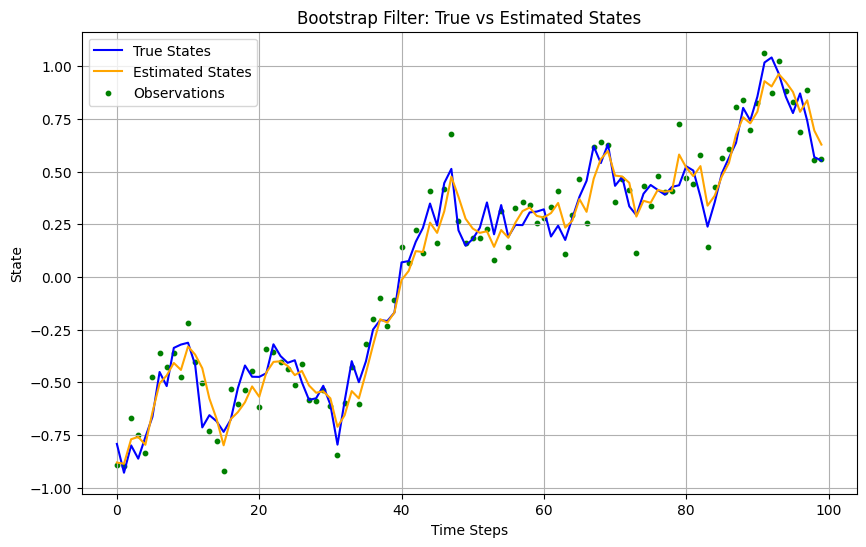

In [12]:
# Simulated parameters
num_particles = 1000
prior_mean = 0.0
prior_std = 1.0
T = 100

# Generate true states and observations
true_states = np.zeros(T)
observations = np.zeros(T)

true_states[0] = np.random.normal(prior_mean, prior_std)
observations[0] = true_states[0] + np.random.normal(0, 0.1)

for t in range(1, T):
    true_states[t] = true_states[t - 1] + np.random.normal(0, 0.1)
    observations[t] = true_states[t] + np.random.normal(0, 0.1)

# Initialize and run bootstrap filter
bootstrap_filter = BootstrapFilter(num_particles, prior_mean, prior_std)
estimated_states = bootstrap_filter.run_filter(observations)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(true_states, label="True States", color="blue")
plt.plot(estimated_states, label="Estimated States", color="orange")
plt.scatter(range(T), observations, label="Observations", color="green", s=10)
plt.xlabel("Time Steps")
plt.ylabel("State")
plt.title("Bootstrap Filter: True vs Estimated States")
plt.legend()
plt.grid()
plt.show()

## 3. PMMH-type algorithm to estimate the parameters of the model

In [13]:
class PMMH:
    def __init__(self, num_particles, num_iterations):
        """
        Initialize the Particle Marginal Metropolis-Hastings (PMMH) algorithm.

        Parameters:
        - num_particles: Number of particles in the bootstrap filter.
        - num_iterations: Number of iterations for the MCMC sampler.
        """
        self.num_particles = num_particles
        self.num_iterations = num_iterations

    def log_prior(self, params):
        """
        Compute the log-prior of the parameters.

        Parameters:
        - params: Dictionary of model parameters.

        Returns:
        - log_prior: Logarithm of the prior probability.
        """
        priors = {
            'kappa': (0, 5),
            'theta': (0, 1),
            'sigma': (0, 1),
            'rho': (-1, 1),
            'eta_s': (0, 5),
            'eta_v': (0, 5),
            'lambda': (0, 5),
            'mu_s': (-0.1, 0.1),
            'sigma_s': (0, 0.2),
            'eta_js': (0, 0.2),
            'mu_v': (0, 0.2),
            'eta_jv': (0, 0.2),
            'rho_j': (-1, 1),
            'sigma_c': (0, 5),
        }

        log_prior = 0
        for key, (lower, upper) in priors.items():
            if lower <= params[key] <= upper:
                log_prior += -np.log(upper - lower)
            else:
                return -np.inf  # Parameter out of bounds

        return log_prior

    def bootstrap_filter(self, observations, params):
        """
        Bootstrap filter to compute the likelihood of the observations given the parameters.

        Parameters:
        - observations: Observed data (y_t).
        - params: Dictionary of model parameters.

        Returns:
        - log_likelihood: Log-likelihood of the observations.
        """
        N = self.num_particles
        T = len(observations)
        particles = np.random.normal(0, 1, N)
        weights = np.ones(N) / N

        log_likelihood = 0

        for t in range(T):
            y_t = observations[t]
            new_particles = particles + params['kappa'] * (params['theta'] - particles) + \
                            params['sigma'] * np.sqrt(np.maximum(particles, 0)) * np.random.normal(0, 1, N)
            new_particles = np.maximum(new_particles, 0)

            likelihoods = np.exp(-0.5 * ((y_t - new_particles) ** 2) / params['sigma_c']**2)
            weights *= likelihoods

            # Prevent division by zero or NaN
            if np.sum(weights) == 0 or np.any(np.isnan(weights)):
                weights.fill(1.0 / N)  # Reset to uniform weights
            else:
                weights /= np.sum(weights)

            log_likelihood += np.log(np.sum(weights))
            indices = np.random.choice(N, N, p=weights)
            particles = new_particles[indices]
            weights.fill(1.0 / N)

        return log_likelihood

    def run(self, observations):
        """
        Run the PMMH algorithm to estimate the parameters of the model.

        Parameters:
        - observations: Observed data (y_t).

        Returns:
        - samples: List of sampled parameters.
        """
        samples = []
        current_params = {
            'kappa': 2.0,
            'theta': 0.04,
            'sigma': 0.3,
            'rho': -0.5,
            'eta_s': 1.0,
            'eta_v': 1.0,
            'lambda': 1.0,
            'mu_s': 0.01,
            'sigma_s': 0.05,
            'eta_js': 0.05,
            'mu_v': 0.05,
            'eta_jv': 0.05,
            'rho_j': -0.5,
            'sigma_c': 1.0,
        }

        current_log_prior = self.log_prior(current_params)
        current_log_likelihood = self.bootstrap_filter(observations, current_params)
        current_log_posterior = current_log_prior + current_log_likelihood

        for _ in range(self.num_iterations):
            proposed_params = {
                key: np.random.normal(current_params[key], 0.05)
                for key in current_params
            }
            proposed_log_prior = self.log_prior(proposed_params)

            if proposed_log_prior == -np.inf:
                samples.append(current_params)
                continue

            proposed_log_likelihood = self.bootstrap_filter(observations, proposed_params)
            proposed_log_posterior = proposed_log_prior + proposed_log_likelihood

            acceptance_ratio = np.exp(proposed_log_posterior - current_log_posterior)
            if np.random.uniform(0, 1) < acceptance_ratio:
                current_params = proposed_params
                current_log_prior = proposed_log_prior
                current_log_likelihood = proposed_log_likelihood
                current_log_posterior = proposed_log_posterior

            samples.append(current_params)

        return samples


In [15]:
!pip install ace_tools


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
# Import necessary modules
import pandas as pd

# Define the PMMH algorithm with the parameters provided in the simulation
pmmh = PMMH(num_particles=1000, num_iterations=500)  # Number of particles and iterations can be adjusted

# Run the PMMH algorithm with the observed variance data (V)
estimated_samples = pmmh.run(observations=V)

# Extract posterior means and standard deviations for each parameter
posterior_means = {param: np.mean([sample[param] for sample in estimated_samples]) for param in estimated_samples[0].keys()}
posterior_stds = {param: np.std([sample[param] for sample in estimated_samples]) for param in estimated_samples[0].keys()}

# True parameter values from the paper
true_params = {
    "kappa": 0.9613,
    "theta": 0.0282,
    "sigma": 0.3586,
    "rho": -0.9191,
    "eta_s": 2.7095,
    "eta_v": 0.6239,
    "lambda": 0.7249,
    "mu_s": 0.0320,
    "sigma_s": 0.0872,
    "eta_js": 0.0562,
    "mu_v": 0.0727,
    "eta_jv": 0.0562,
    "rho_j": -0.7382,
    "sigma_c": 3.0978,
}

# Compare posterior means with true parameters
comparison_df = pd.DataFrame({
    "Parameter": true_params.keys(),
    "True Value": true_params.values(),
    "Posterior Mean": [posterior_means[key] for key in true_params.keys()],
    "Posterior Std": [posterior_stds[key] for key in true_params.keys()],
})

# Print the DataFrame for inspection
print("PMMH Parameter Estimates vs True Values")
display(comparison_df)

PMMH Parameter Estimates vs True Values


,Parameter,True Value,Posterior Mean,Posterior Std
0,kappa,0.9613,2.314625,0.205862
1,theta,0.0282,0.242908,0.153130
2,sigma,0.3586,0.674686,0.169097
3,rho,-0.9191,-0.475397,0.155094
4,eta_s,2.7095,0.940650,0.140095
5,eta_v,0.6239,0.765496,0.148915
6,lambda,0.7249,0.425473,0.196620
7,mu_s,0.0320,0.014220,0.053289
8,sigma_s,0.0872,0.108815,0.055345
9,eta_js,0.0562,0.099914,0.057643


## 4. Comparison of the results with the paper

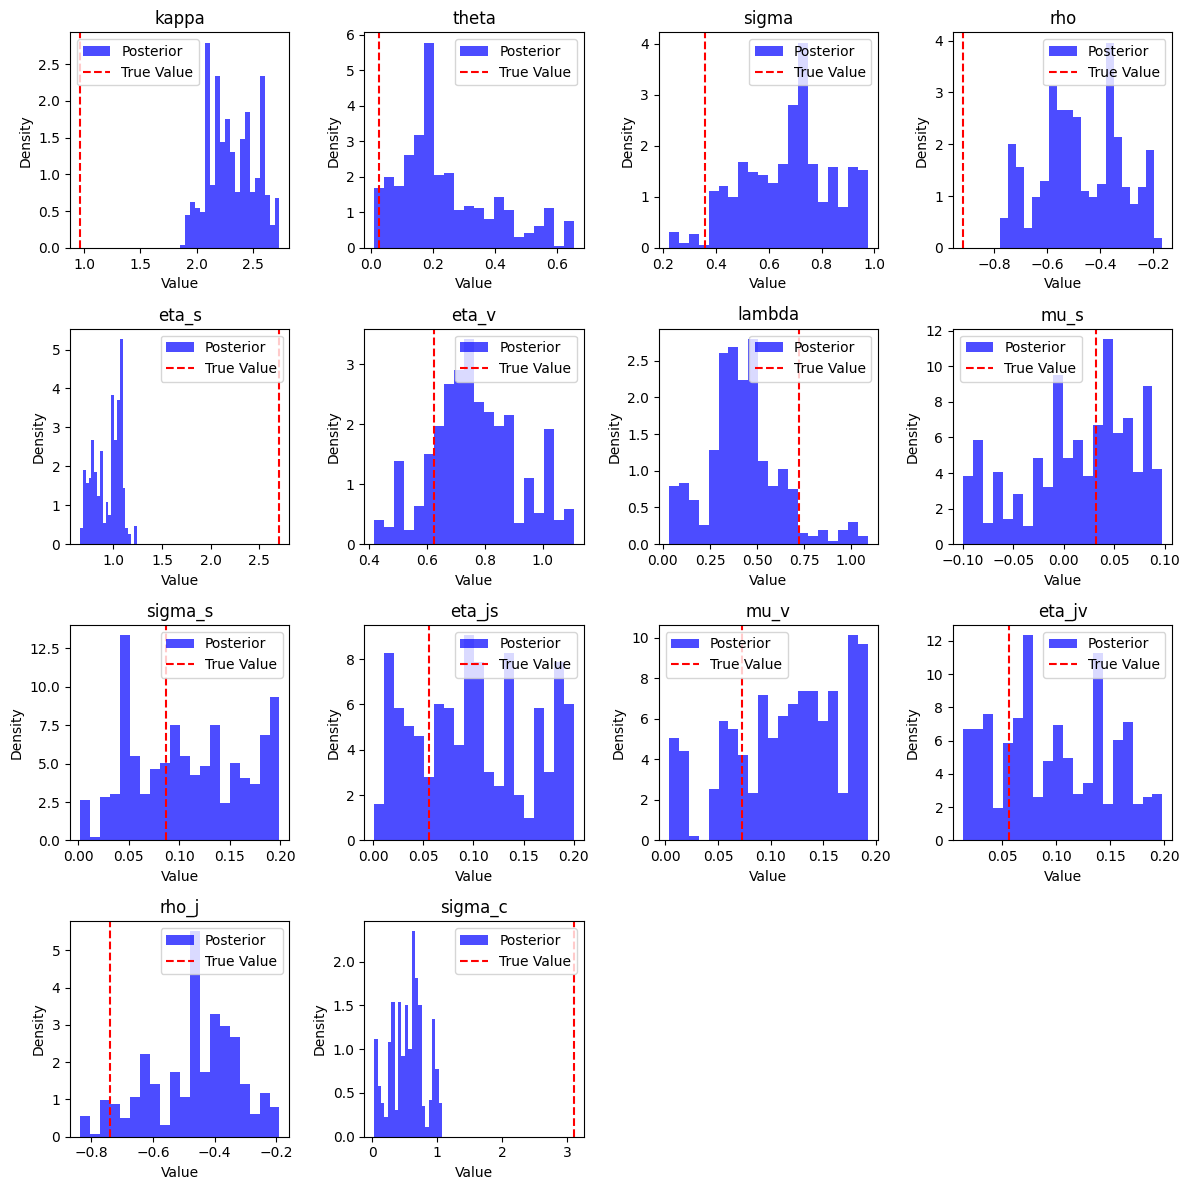

In [19]:
# Plot comparison for visual inspection
plt.figure(figsize=(12, 12))
for i, param in enumerate(true_params.keys()):
    plt.subplot(4, 4, i + 1)
    param_samples = [sample[param] for sample in estimated_samples]
    plt.hist(param_samples, bins=20, alpha=0.7, color='blue', density=True, label='Posterior')
    plt.axvline(true_params[param], color='red', linestyle='--', label='True Value')
    plt.title(param)
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()

plt.show()